# Taller corte 2 - Visión por computadora

#Jerónimo Manriquez
#Wilberson Osorio

# Introducción 

Antes de todo, el dataset usado fue obtenido del paper Deep Learning Method to Detect the Road Cracks and Potholes for Smart Cities, descargados del link https://drive.google.com/drive/folders/1wGmkq5aIXfINNlK8f6Sow1S4AnZilLS9, y se utilizaron las imágenes del set de Test y Validation. 

In [ ]:
import os
import shutil

import cv2
import albumentations as A

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

import xgboost as xgb

In [10]:
# CORRER ESTO SI SE NECESITA REPLICAR EL PROCESO DESDE EL INICIO!

reiniciar = True
if (reiniciar):
    carpeta = os.path.join(os.path.abspath("..") + "/imagenes/imagenes_modificadas")
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
        print(f"Las imagenes modificadas han sido eliminadas.")
    else:
        print(f"La carpeta de imagenes modificadas no existe.")

    carpeta = os.path.join(os.path.abspath("..") + "/output")
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
        print(f"Los outputs han sido eliminados.")
    else:
        print(f"La carpeta no existe.")
        
carpeta_modificaciones = os.path.join(os.path.abspath("..") + "/imagenes/imagenes_modificadas")
carpeta_salida = os.path.join(os.path.abspath("..") + "/output")

os.makedirs(carpeta_modificaciones, exist_ok=True)
os.makedirs(carpeta_salida, exist_ok=True)

Las imagenes modificadas han sido eliminadas.
Los outputs han sido eliminados.


# 1. Transformaciones Geométricas y Data Augmentation

Uso de rotaciones, escalados, traslaciones o correcciones geométricas para aumentar el
dataset o alinear imágenes.

In [ ]:
# Mantenemos una lista de la categoria que pertenece cada imagen, ya que una imagen puede crear mas
# 0: Normal, 1: Grieta, 2: Hueco.
nombres_y = {}

tamano_imagen = (256, 256)

# === TRANSFORMACIONES PARA DATA AUGMENTATION ===
transform = A.Compose([
    A.Rotate(limit=20, p=0.8, border_mode=cv2.BORDER_REFLECT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ElasticTransform(p=0.1),
    A.Resize(height=tamano_imagen[0], width=tamano_imagen[1], p=1.0)
])

def recortar_bordes_negros(imagen):
    gray = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
    coords = cv2.findNonZero(gray)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return imagen[y:y+h, x:x+w]
    else:
        return imagen  # Por si es toda negra

# === AUMENTO DE DATASET (N versiones por imagen) ===
num_augmentations = 4

#output
carpeta_output = os.path.join(carpeta_modificaciones, 'augmentation')
os.makedirs(carpeta_output, exist_ok=True)

#input
normal = os.path.join(os.path.abspath(".."), "imagenes/normal")
grietas = os.path.join(os.path.abspath(".."), "imagenes/grietas")
huecos = os.path.join(os.path.abspath(".."), "imagenes/huecos")

image_paths = [normal, grietas, huecos]
x = 0

for categoria, carpeta in enumerate(image_paths):
    file_path = os.path.join(os.path.abspath('..'), 'imagenes')
    file_path = os.path.join(file_path, carpeta)
    for filename in os.listdir(carpeta):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(file_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            for i in range(num_augmentations):
                augmented = transform(image=img_rgb)['image']
                recortada = recortar_bordes_negros(augmented)
                recortada = cv2.resize(recortada, tamano_imagen)
                nombre_img = f"{x}_{i}.jpg"
                x = x + 1
                nombres_y[nombre_img] = categoria
                out_path = os.path.join(carpeta_output, nombre_img)
                cv2.imwrite(out_path, cv2.cvtColor(recortada, cv2.COLOR_RGB2BGR))

print("Dataset aumentado con éxito.")

Dataset aumentado con éxito.


# 2. Filtrado y Convolución

Se experimento con los filtros de Sobel y Prewitt, donde como grupo se escogió Sobel, ya que nos pareció dar mejores resultados, ya que las imágenes tenían características más pronunciadas. 

## Sobel

In [12]:
# === APLICAR FILTRO SOBEL A TODAS LAS IMÁGENES AUGMENTED ===
carpeta_input = os.path.join(carpeta_modificaciones, 'augmentation')
carpeta_output = os.path.join(carpeta_modificaciones, 'filtro')
os.makedirs(carpeta_output, exist_ok=True)

# Procesar cada imagen
for filename in os.listdir(carpeta_input):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(carpeta_input, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        sobel_combined = cv2.magnitude(sobelx, sobely)

        # Normalizar a 8 bits y guardar
        sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)
        sobel_combined = sobel_combined.astype(np.uint8)

        out_path = os.path.join(carpeta_output, filename)
        cv2.imwrite(out_path, sobel_combined)

print("Sobel completado.")

Sobel completado.


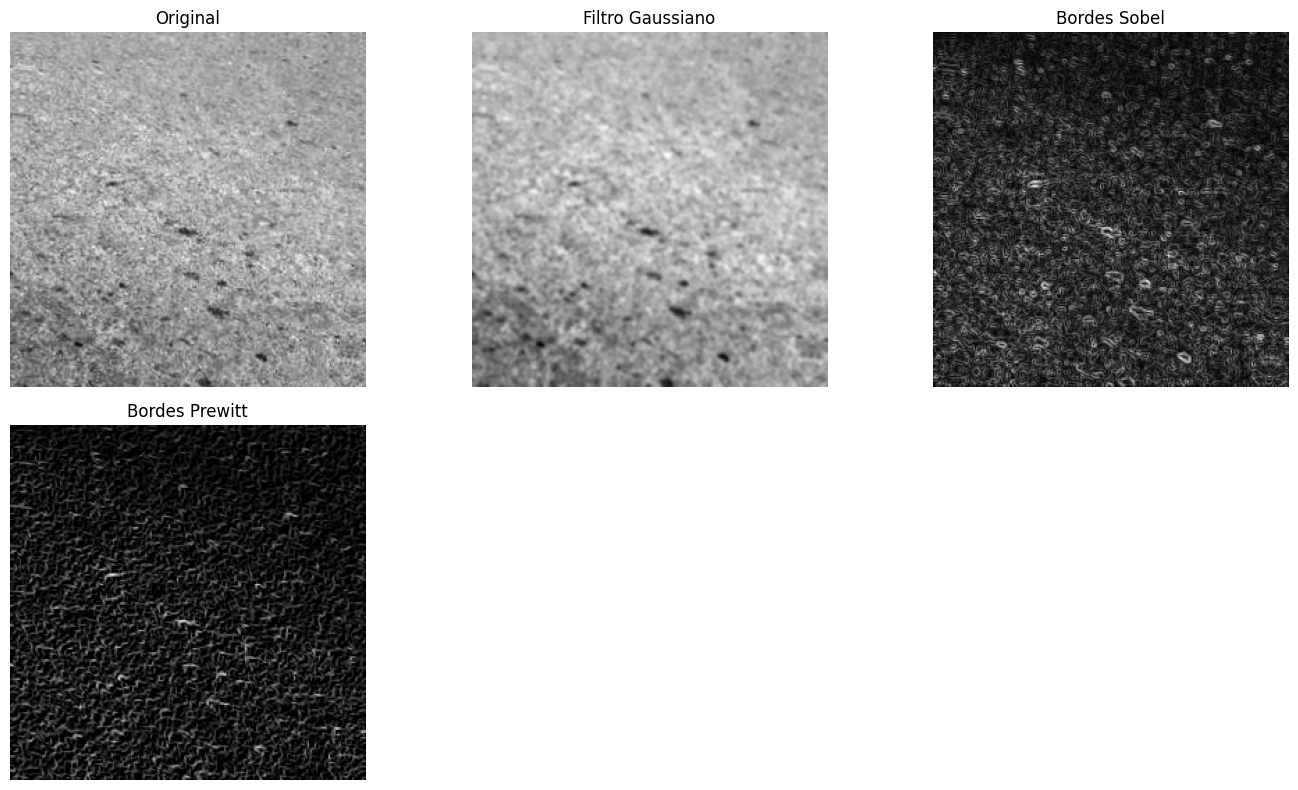

In [13]:
visualizar = True 
if (visualizar):
    # === CARGAR UNA IMAGEN PARA FILTRADO ===
    image_name = os.listdir(carpeta_input)[0]
    img = cv2.imread(os.path.join(carpeta_input, image_name), cv2.IMREAD_GRAYSCALE)  #Escala de grises

    # === 1. FILTRO GAUSSIANO (suavizado) ===
    gaussian = cv2.GaussianBlur(img, (5, 5), 0)

    # === 2. FILTROS SOBEL (bordes en X y Y) ===
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # === 3. FILTRO PREWITT (manual con kernels) ===
    prewitt_kernel_x = np.array([[1, 0, -1],
                                [1, 0, -1],
                                [1, 0, -1]])

    prewitt_kernel_y = np.array([[1,  1,  1],
                                [0,  0,  0],
                                [-1, -1, -1]])

    prewitt_x = cv2.filter2D(img, -1, prewitt_kernel_x)
    prewitt_y = cv2.filter2D(img, -1, prewitt_kernel_y)
    prewitt_combined = cv2.magnitude(prewitt_x.astype(np.float32), prewitt_y.astype(np.float32))

    # === VISUALIZACIÓN ===
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(gaussian, cmap='gray')
    plt.title("Filtro Gaussiano")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(sobel_combined, cmap='gray')
    plt.title("Bordes Sobel")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(prewitt_combined, cmap='gray')
    plt.title("Bordes Prewitt")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Detección de bordes y umbralización


In [14]:
carpeta_input = os.path.join(carpeta_modificaciones, 'filtro')
carpeta_output = os.path.join(carpeta_modificaciones, 'otsu')
os.makedirs(carpeta_output, exist_ok=True)

# Procesar cada imagen
for filename in os.listdir(carpeta_input):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(carpeta_input, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        _, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cv2.imwrite(os.path.join(carpeta_output, filename), otsu)

print("Detección de bordes y umbralización completadas para todas las imágenes.")

Detección de bordes y umbralización completadas para todas las imágenes.


# 5. Feature Detection y Descriptores (SIFT)

Extracción de puntos clave para clasificadores.

In [15]:
# === SIFT SOBRE LAS IMÁGENES CLAHE ENHANCED ===
carpeta_input = os.path.join(carpeta_modificaciones, 'otsu')

numDescriptores = 512 # por como funciona SIFT estos seran los de mas alta calidad

sift = cv2.SIFT_create(nfeatures = numDescriptores)
all_descriptors = []
datos_imagenes = []

# Procesar cada imagen
for filename in os.listdir(carpeta_input):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(carpeta_input, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Detectar keypoints y descriptores
        keypoints, descriptors = sift.detectAndCompute(img, None)

        if (type(descriptors) == type(None)):
            continue # :<

        if (len(descriptors) < numDescriptores):
            continue
        
        all_descriptors.append(descriptors)
        datos_imagenes.append(filename)

print('Se consiguieron {} imagenes con descriptores.'.format(len(all_descriptors)))

Se consiguieron 1053 imagenes con descriptores.


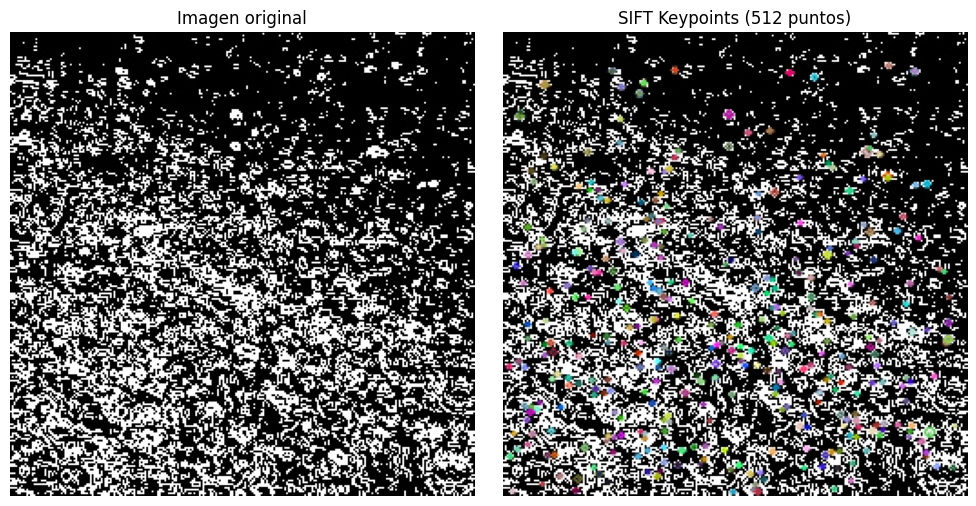

In [16]:
carpeta_input = os.path.join(carpeta_modificaciones, 'otsu')

visualizar = True
if (visualizar):
    # === MOSTRAR UNA IMAGEN CLAHE + SIFT ===
    sample_image = os.listdir(carpeta_input)[0]
    img = cv2.imread(os.path.join(carpeta_input, sample_image), cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img_sift = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Imagen original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_sift)
    plt.title(f"SIFT Keypoints ({len(keypoints)} puntos)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 6. Bag of Visual Words (BoVW) o VLA

Construcción de un vocabulario visual a partir de descriptores de puntos clave.

In [17]:
print("Entrenando KMeans para construir el vocabulario visual...")
k = 100 
stacked_descriptors = np.vstack(all_descriptors)
modelo = KMeans(n_clusters=k, random_state=7723)
modelo = modelo.fit(stacked_descriptors)

Entrenando KMeans para construir el vocabulario visual...


In [18]:
print("Generando vectores BoVW por imagen...")
X = []
y = []

for i in range(len(all_descriptors)):
    descriptor = all_descriptors[i]
    words = modelo.predict(descriptor)
    hist, _ = np.histogram(words, bins=np.arange(k+1))
    hist = hist.astype(np.float32)
    X.append(hist)
    y.append(nombres_y[datos_imagenes[i]])

Generando vectores BoVW por imagen...


# 7. Machine Learning Pipeline en Scikit-Learn


Construcción de un pipeline modular:

▪ Transformaciones de datos

▪ Selección de características

▪ Entrenamiento de clasificador (SVM, Random Forest, etc.) o Segmentación no
supervisada (k-means, GMM, etc.).

▪ Evaluación y Métricas.

Primero se crearán funciones modulares, las cuales combinan el funcionamiento de las funciones anteriores y las permiten insertar en un pipeline de sklearn. 

Esto permite realizar todos los procesos en un solo paso y de forma unificada. 

In [19]:
def TransformacionesIniciales(X):
    tamano_imagen = (256, 256)
    num_augmentations = 4 
    
    print('Empezando proceso...')

    transform = A.Compose([
        A.Rotate(limit=20, p=0.8, border_mode=cv2.BORDER_REFLECT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ElasticTransform(p=0.1),
        A.Resize(height=tamano_imagen[0], width=tamano_imagen[1], p=1.0)
    ])

    def recortar_bordes_negros(imagen):
        gray = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
        coords = cv2.findNonZero(gray)
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            return imagen[y:y+h, x:x+w]
        else:
            return imagen  # Por si es toda negra

    #input
    normal = os.path.join(os.path.abspath(".."), "imagenes/normal")
    grietas = os.path.join(os.path.abspath(".."), "imagenes/grietas")
    huecos = os.path.join(os.path.abspath(".."), "imagenes/huecos")
    image_paths = [normal, grietas, huecos]

    X = []
    y = []

    for categoria, carpeta in enumerate(image_paths):
        file_path = os.path.join(os.path.abspath('..'), 'imagenes')
        file_path = os.path.join(file_path, carpeta)
        for filename in os.listdir(carpeta):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(file_path, filename)
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                for i in range(num_augmentations):
                    augmented = transform(image=img_rgb)['image']
                    recortada = recortar_bordes_negros(augmented)
                    recortada = cv2.resize(recortada, tamano_imagen)
                    recortada = cv2.cvtColor(recortada, cv2.COLOR_RGB2BGR)
                    X.append(recortada)
                    y.append(categoria)


    print("Dataset aumentado con éxito.")
    return [X, y]

In [20]:
def TransformacionDatos(X):
    print('Empezando transformacion de datos...')
    imagenes = []

    for img in X[0]:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Filtrado
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        img = cv2.magnitude(sobelx, sobely)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.uint8(img) 

        # Deteccion de bordes
        _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Ecualizacion
        imagenes.append(img)

    print('Transformacion de datos completada.')
    return [imagenes, X[1]]

In [21]:
def SeleccionCaracteristicas(X):
    X, y = X[0], X[1]

    all_descriptors = []
    new_X = []
    new_y = []

    print('Empezando seleccion de caracteristicas...')
    numDescriptores = 1024 # por como funciona SIFT estos seran los de mas alta calidad
    sift = cv2.SIFT_create(nfeatures = numDescriptores)

    print('Realizando SIFT...')
    for i in range(len(X)):
        imagen = X[i]
        _, descriptors = sift.detectAndCompute(imagen, None)

        if (type(descriptors) == type(None)):
            continue # :<
        if (len(descriptors) < numDescriptores):
            continue
        
        all_descriptors.append(descriptors)
        new_y.append(y[i])
    
    print('Realizando Bag of Visual Words...')
    k = 64 
    stacked_descriptors = np.vstack(all_descriptors)
    modelo = KMeans(n_clusters=k, random_state=7723)
    modelo = modelo.fit(stacked_descriptors)

    print('Generando descriptores de BoVW...')
    for descriptor in all_descriptors:
        words = modelo.predict(descriptor)
        hist, _ = np.histogram(words, bins=np.arange(k))
        hist = hist.astype(np.float32)
        new_X.append(hist)

    print('Finalizado! Se crearon {} histogramas.'.format(len(new_X)))
    return [new_X, new_y]

In [22]:
pipe_inicial = FunctionTransformer(TransformacionesIniciales)
pipe_transformacion = FunctionTransformer(TransformacionDatos)
pipe_caracteristicas = FunctionTransformer(SeleccionCaracteristicas)

pipeline_preprocesamiento = Pipeline([
    ('inicio', pipe_inicial),
    ('transformaciones', pipe_transformacion),
    ('caracteristicas', pipe_caracteristicas),
])

pipeline_entrenamiento = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier())
])

Ya que se han generado los pipelines se puede hacer el cálculo sobre estas. 

---

In [23]:
X = pipeline_preprocesamiento.transform(0)
X, y = X[0], X[1]

Empezando proceso...
Dataset aumentado con éxito.
Empezando transformacion de datos...
Transformacion de datos completada.
Empezando seleccion de caracteristicas...
Realizando SIFT...
Realizando Bag of Visual Words...
Generando descriptores de BoVW...
Finalizado! Se crearon 3308 histogramas.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 7723)

res = pipeline_entrenamiento.fit(X_train, y_train)

In [25]:
y_pred = res.predict(X_test)

print('Al examinar el conjunto test, da los siguientes resultados:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1:', f1_score(y_test, y_pred, average='weighted'))

Al examinar el conjunto test, da los siguientes resultados:
Accuracy: 0.8126888217522659
Precision: 0.8044421292696438
Recall: 0.8126888217522659
F1: 0.8046515883968745


# 8. Optimización de Hiperparámetros

In [27]:
grid_search = [{
    "xgb__learning_rate": [0.05, 0.10, 0.15, 0.2, 0.3, 0.4],
    "xgb__gamma": [0.0, 0.1, 0.2, 0.3],
    "xgb__max_depth": [3, 4, 5, 6, 8, None],
    "xgb__min_child_weight": [1, 3, 5, 7, 9],
    "xgb__lambda": [0.5, 1, 1.5, 2],
    "xgb__colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1]
}]

paramSearch = HalvingRandomSearchCV(
        pipeline_entrenamiento,
        grid_search,
        factor = 2,
        n_jobs = -1) # Usara todos los nucleos!!!

paramSearch.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               feature_weights=None,
                                                               gamma=None,
                                                               grow_polic...
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))]),
                      factor=2, n_jobs=-1,
                      param_distributions=[{'xgb__colsample_bytree': [0.2, 0.4,
                                                                      0.6, 0.8,
                                                                      1],
                                            'xgb__gamma': [0.0, 0.1, 0.2, 0.3],
                                            'xgb__lambda': [0.5, 1, 1.5, 2],
                                            'xgb__learning_rate': [0.05, 0.1,
                                                                   0.15, 0.2,
                                                                   0.3, 0.4],
                                            'xgb__max_depth': [3, 4, 5, 6, 8,
                                                               None],
                                            'xgb__min_child_weight': [1, 3, 5,
                                                                      7, 9]}])

In [ ]:
res = paramSearch.best_estimator_
y_pred = res.predict(X_test)

print('Al examinar el conjunto test, da los siguientes resultados:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1:', f1_score(y_test, y_pred, average='weighted'))

Al examinar el conjunto test, da los siguientes resultados:
Accuracy: 0.8021148036253777
Precision: 0.7927649773633514
Recall: 0.8021148036253777
F1: 0.7908377497494403
